## Content in this notebook
 - Import and load data
 - Raw model selection
 - Raw model parameter tuning
 - Feature engineered model selection
 - Feature engineered parameter tuning

## Import and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from sklearn.model_selection import train_test_split
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
import gc


%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn import datasets, neighbors, linear_model

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


In [4]:
talking = pd.read_csv('./projdata/model_selection2m.csv', parse_dates = ['click_time'])

## Raw model selectiom

In [5]:
# transform click_time into day, hour, minute and second
talking['day'] = talking['click_time'].dt.day
talking['hour'] = talking['click_time'].dt.hour
talking['minute'] = talking['click_time'].dt.minute
talking['second'] = talking['click_time'].dt.second
talking.head()

,Unnamed: 0,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,31655873,197955,9,1,13,258,2017-11-07 06:45:50,NaN,0,7,6,45,50
1,105493957,5314,2,1,27,477,2017-11-08 11:17:28,NaN,0,8,11,17,28
2,146879719,48782,18,1,13,107,2017-11-09 04:33:03,NaN,0,9,4,33,3
3,173149719,83230,3,1,13,115,2017-11-09 12:27:31,NaN,0,9,12,27,31
4,20397653,100896,9,1,27,445,2017-11-07 03:20:18,NaN,0,7,3,20,18


In [5]:
heads = talking.columns
print(heads)
for i in list(range(0,5)) + list(range(-1, -6, -1)):
    talking[heads[i]] = talking[heads[i]].astype('category')
talking.info()

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day', 'hour', 'minute', 'second'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 12 columns):
ip                 category
app                category
device             category
os                 category
channel            category
click_time         datetime64[ns]
attributed_time    object
is_attributed      category
day                category
hour               category
minute             category
second             category
dtypes: category(10), datetime64[ns](1), object(1)
memory usage: 66.3+ MB


In [6]:
talking = talking.drop(['attributed_time','click_time'],axis=1)

In [7]:
# down sample the train set
df_majority = talking[talking['is_attributed']==0]
df_minority = talking[talking['is_attributed']==1]

df_majority_downsampled = df_majority.sample(replace=False,    # sample without replacement
                                frac=len(df_minority)/len(df_majority),     
                                random_state=42) # reproducible results

balanced_train = pd.concat([df_majority_downsampled, df_minority])
# balanced_train = balanced_train.sample(frac=1)

# balanced_train = balanced_train.drop(columns=['click_time','attributed_time'])
balanced_train['is_attributed'] = balanced_train['is_attributed'].astype('int64')

In [8]:
y = balanced_train['is_attributed']
X = balanced_train.drop(['is_attributed'], axis=1)
X.shape

(9776, 10)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
pip_knn = Pipeline([('clf', KNeighborsClassifier())])
pip_rfc = Pipeline([('clf', RandomForestClassifier(n_estimators=100))])
pip_lr = Pipeline([('clf', LogisticRegression(solver='lbfgs'))])
pip_gnb = Pipeline([('clf', GaussianNB())])
pip_gbc = Pipeline([('clf', GradientBoostingClassifier())])
pip_mlp = Pipeline([('clf', MLPClassifier())])
pip_svc1 = Pipeline([('clf', LinearSVC())])
pip_svc2 = Pipeline([('clf', SVC())])
pip_xgb = Pipeline([('clf', XGBClassifier())])
# pip_lgb = Pipeline([('clf', LGBMClassifier())])

# pipelines = [pip_knn, pip_rfc, pip_lr, pip_gnb, pip_gbc, pip_mlp, pip_svc1, pip_svc2, pip_xgb, pip_lgb]
pipelines = [pip_knn, pip_rfc, pip_lr, pip_gnb, pip_gbc, pip_mlp, pip_svc1, pip_svc2, pip_xgb]

In [11]:
warnings.filterwarnings('ignore')

plot_df = pd.DataFrame(columns=['type','roc_auc','f1_score'])
for i in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i*2)
    for pipe in pipelines:
        pipe.fit(X_train.values, y_train)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        a = roc_auc_score(y_test, pipe.predict(X_test.values))
        b = f1_score(y_test,pipe.predict(X_test.values))
        plot_df = plot_df.append({'type':name,'roc_auc':a, 'f1_score':b}, ignore_index=True)

In [12]:
plot_df.sort_values(['roc_auc', 'f1_score'], ascending=[False, False]).head(10)

,type,roc_auc,f1_score
532,RandomForestClassifier,0.925606,0.922085
539,XGBClassifier,0.921459,0.916983
481,GradientBoostingClassifier,0.920641,0.915121
535,GradientBoostingClassifier,0.919966,0.915948
586,RandomForestClassifier,0.919498,0.915054
262,RandomForestClassifier,0.919454,0.914847
674,XGBClassifier,0.919366,0.913937
485,XGBClassifier,0.919125,0.913483
895,GradientBoostingClassifier,0.919025,0.913841
845,XGBClassifier,0.918990,0.914720


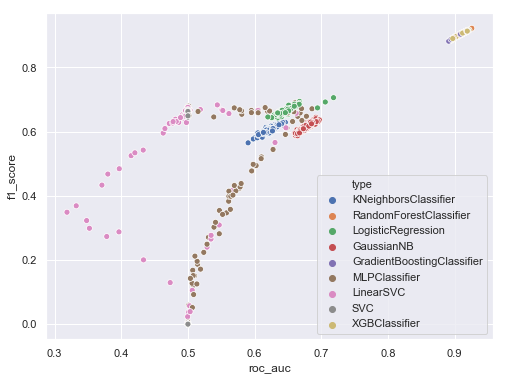

In [13]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.scatterplot(x="roc_auc", y="f1_score", hue="type", data=plot_df)

## Raw grid search

In [14]:
def grid_search_rfc(X_train, X_test, y_train, y_test):
    rfc = RandomForestClassifier()   
    grid_params = {'n_estimators': [10, 50, 100],
                   'max_features': ['auto'],
                   'max_depth' : range(5,10),
                   'criterion' :['gini', 'entropy']}
    gs = GridSearchCV(estimator=rfc,  
                      param_grid=grid_params,
                      scoring='roc_auc',
                      cv=5)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    roc_auc = roc_auc_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    best_params = gs.best_params_
    return roc_auc, f1, best_params


In [15]:
grid_search_rfc(X_train, X_test, y_train, y_test)

(0.9239114990358266,
 0.9092957746478874,
 {'criterion': 'entropy',
  'max_depth': 9,
  'max_features': 'auto',
  'n_estimators': 100})

In [16]:
def grid_search_gbc(X_train, X_test, y_train, y_test):
    gbc = GradientBoostingClassifier()
    grid_params = {'n_estimators': [10, 50, 100],
                   'learning_rate': [0.01, 0.05, 0.1]}
    gs = GridSearchCV(estimator=gbc,  
                      param_grid=grid_params,
                      scoring='roc_auc',
                      cv=5)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    roc_auc = roc_auc_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    best_params = gs.best_params_
    return roc_auc, f1, best_params

In [17]:
grid_search_gbc(X_train, X_test, y_train, y_test)

(0.9246802847855778,
 0.9138410227904391,
 {'learning_rate': 0.1, 'n_estimators': 100})

In [18]:
def grid_search_xgb(X_train, X_test, y_train, y_test):
    xg = XGBClassifier()
    grid_params = {'n_estimators': [100, 200, 400],
                   'learning_rate': [0.1, 0.2, 0.4]}
    gs = GridSearchCV(estimator=xg,  
                      param_grid=grid_params,
                      scoring='roc_auc',
                      cv=5)
    gs.fit(X_train.values, y_train)
    roc_auc = gs.score(X_test.values, y_test)
    best_params = gs.best_params_
    return roc_auc, best_params

In [19]:
grid_search_xgb(X_train, X_test, y_train, y_test)


(0.9650323546657733, {'learning_rate': 0.2, 'n_estimators': 100})

In [20]:
def grid_search_lgb(X_train, X_test, y_train, y_test):
    lg = LGBMClassifier()    
    grid_params = {'n_estimators': [10, 100, 400],
                   'learning_rate': [0.01, 0.1, 0.5]}              
    gs = GridSearchCV(estimator=lg,  
                      param_grid=grid_params,
                      scoring='roc_auc',
                      cv=5)
    gs.fit(X_train.values, y_train)
    roc_auc = gs.score(X_test.values, y_test)
    best_params = gs.best_params_    
    return roc_auc, best_params

In [21]:
grid_search_lgb(X_train, X_test, y_train, y_test)

(0.9669982409113755, {'learning_rate': 0.01, 'n_estimators': 400})

## Feature engineer and model selection

### load test and feature engineer

In [22]:
talking = pd.read_csv('./projdata/model_selection2m.csv', parse_dates = ['click_time'])

In [23]:
def fea_eng(Y):
    X = Y
    X['day'] = X['click_time'].dt.day
    X['hour'] = X['click_time'].dt.hour
    X['minute'] = X['click_time'].dt.minute
    X['second'] = X['click_time'].dt.second
    heads = X.columns
    print(heads)
    for i in list(range(0,5)) + [6]:
        X[heads[i]] = X[heads[i]].astype('category')
    return X

In [24]:
final = fea_eng(talking)

Index(['Unnamed: 0', 'ip', 'app', 'device', 'os', 'channel', 'click_time',
       'attributed_time', 'is_attributed', 'day', 'hour', 'minute', 'second'],
      dtype='object')


In [25]:
# down sample the train set
df_majority = final[final.is_attributed==0]
df_minority = final[final.is_attributed==1]

df_majority_downsampled = df_majority.sample(replace=False,    # sample without replacement
                                frac=len(df_minority)/len(df_majority),     
                                random_state=42) # reproducible results

balanced = pd.concat([df_majority_downsampled, df_minority])
balanced = balanced.sample(frac=1)

# balanced = balanced.drop(columns=['click_time','attributed_time'])
balanced = final.drop(columns=['click_time','attributed_time'])
balanced['is_attributed'] = balanced['is_attributed'].astype('int64')

In [26]:
balanced.columns

Index(['Unnamed: 0', 'ip', 'app', 'device', 'os', 'channel', 'is_attributed',
       'day', 'hour', 'minute', 'second'],
      dtype='object')

In [27]:
test_fe = balanced

In [28]:
test_fe[['day', 'hour', 'minute', 'second']] = test_fe[['day', 'hour', 'minute', 'second']].astype('float')
test_fe[['ip', 'app', 'device', 'os', 'channel']] = test_fe[['ip', 'app', 'device', 'os', 'channel']].astype('category')

In [29]:
# Define all the groupby transformations
groupby_aggregations = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: np.divide(float(len(x)),float(len(x.unique()))), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]



new_features =[]
# Apply all the groupby transformations
for spec in groupby_aggregations:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    new_features.append(new_feature)
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = test_fe[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        test_fe[new_feature] = gp[0].values
    else:
        # train_fe[spec['groupby']] = train_fe[spec['groupby']].astype('category')
        test_fe = test_fe.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

test_fe.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nunique
Grouping by ['app'], and aggregating channel with nunique
Grou

,Unnamed: 0,ip,app,device,os,channel,is_attributed,day,hour,minute,...,ip_nunique_app,ip_day_nunique_hour,ip_app_nunique_os,ip_nunique_device,app_nunique_channel,ip_device_os_nunique_app,ip_device_os_cumcount_app,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour
0,31655873,197955,9,1,13,258,0,7.0,6.0,45.0,...,15,14,4,2,39,5,0,0,0,NaN
1,105493957,5314,2,1,27,477,0,8.0,11.0,17.0,...,78,24,56,25,21,24,0,0,0,34.811841
2,146879719,48782,18,1,13,107,0,9.0,4.0,33.0,...,17,9,3,2,15,6,0,0,0,NaN
3,173149719,83230,3,1,13,115,0,9.0,12.0,27.0,...,20,16,16,2,37,15,0,0,0,NaN
4,20397653,100896,9,1,27,445,0,7.0,3.0,20.0,...,21,16,10,1,39,1,0,0,0,NaN


In [30]:
test_fe['ip_app_channel_var_day'] = test_fe['ip_app_channel_var_day'].fillna(0) 
test_fe['ip_app_os_var_hour'] = test_fe['ip_app_os_var_hour'].fillna(0) 
test_fe['ip_day_channel_var_hour'] = test_fe['ip_day_channel_var_hour'].fillna(0)

In [31]:
X = test_fe.drop(['is_attributed'],axis=1)
y = test_fe[['is_attributed']]
X.columns

Index(['Unnamed: 0', 'ip', 'app', 'device', 'os', 'channel', 'day', 'hour',
       'minute', 'second', 'ip_app_channel_var_day', 'ip_app_os_var_hour',
       'ip_day_hour_count_channel', 'ip_app_count_channel',
       'ip_app_os_count_channel', 'ip_app_day_hour_count_channel',
       'ip_app_channel_mean_hour', 'app_AvgViewPerDistinct_ip',
       'app_count_channel', 'channel_count_app', 'ip_nunique_channel',
       'ip_nunique_app', 'ip_day_nunique_hour', 'ip_app_nunique_os',
       'ip_nunique_device', 'app_nunique_channel', 'ip_device_os_nunique_app',
       'ip_device_os_cumcount_app', 'ip_cumcount_app', 'ip_cumcount_os',
       'ip_day_channel_var_hour'],
      dtype='object')

### load train and feature engineered

In [32]:
talking = pd.read_csv('./projdata/param_tuning18m.csv') 
talking['click_time'] = pd.to_datetime(talking['click_time'], errors='coerce')

In [33]:
# transform click_time into day, hour, minute and second
talking['day'] = talking['click_time'].dt.day
talking['hour'] = talking['click_time'].dt.hour
talking['minute'] = talking['click_time'].dt.minute
talking['second'] = talking['click_time'].dt.second
talking.head()

,Unnamed: 0,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,92895533,83604,64,1,13,459,2017-11-08 07:18:18,NaN,0,8,7,18,18
1,22237114,28021,3,1,13,409,2017-11-07 03:54:37,NaN,0,7,3,54,37
2,173801870,44456,3,1,15,480,2017-11-09 12:39:05,NaN,0,9,12,39,5
3,44049831,134076,9,1,13,258,2017-11-07 10:55:26,NaN,0,7,10,55,26
4,80845475,138561,6,1,13,459,2017-11-08 03:33:21,NaN,0,8,3,33,21


In [34]:
# ip, app, device, os, channel, is_attributed and the time features we just created
# are encoded to be integers, we tranform them into categorical data
heads = talking.columns
print(heads)
for i in list(range(0,5)) + [6]:
    talking[heads[i]] = talking[heads[i]].astype('category')
talking.info()

Index(['Unnamed: 0', 'ip', 'app', 'device', 'os', 'channel', 'click_time',
       'attributed_time', 'is_attributed', 'day', 'hour', 'minute', 'second'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000000 entries, 0 to 17999999
Data columns (total 13 columns):
Unnamed: 0         category
ip                 category
app                category
device             category
os                 category
channel            int64
click_time         category
attributed_time    object
is_attributed      int64
day                int64
hour               int64
minute             int64
second             int64
dtypes: category(6), int64(6), object(1)
memory usage: 2.0+ GB


In [35]:
# down sample the train set
df_majority = talking[talking.is_attributed==0]
df_minority = talking[talking.is_attributed==1]

df_majority_downsampled = df_majority.sample(replace=False,    # sample without replacement
                                frac=len(df_minority)/len(df_majority),     
                                random_state=42) # reproducible results

balanced_train = pd.concat([df_majority_downsampled, df_minority])
balanced_train = balanced_train.sample(frac=1)

balanced_train = balanced_train.drop(columns=['click_time','attributed_time'])
balanced_train['is_attributed'] = balanced_train['is_attributed'].astype('int64')

In [36]:
# split 20m into 2m train data and 18m validation data.
train = balanced_train.sample(frac=0.1, replace=False, random_state = 42)
valid = balanced_train.drop(train.index)

In [37]:
train_fe = train

In [38]:
train_fe[['day', 'hour', 'minute', 'second']] = train_fe[['day', 'hour', 'minute', 'second']].astype('float')
train_fe[['ip', 'app', 'device', 'os', 'channel']] = train_fe[['ip', 'app', 'device', 'os', 'channel']].astype('category')

In [39]:
# Define all the groupby transformations
groupby_aggregations = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: np.divide(float(len(x)),float(len(x.unique()))), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]



new_features =[]
# Apply all the groupby transformations
for spec in groupby_aggregations:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    new_features.append(new_feature)
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = train_fe[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        train_fe[new_feature] = gp[0].values
    else:
        # train_fe[spec['groupby']] = train_fe[spec['groupby']].astype('category')
        train_fe = train_fe.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

train_fe.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nunique
Grouping by ['app'], and aggregating channel with nunique
Grou

,Unnamed: 0,ip,app,device,os,channel,is_attributed,day,hour,minute,...,ip_nunique_app,ip_day_nunique_hour,ip_app_nunique_os,ip_nunique_device,app_nunique_channel,ip_device_os_nunique_app,ip_device_os_cumcount_app,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour
0,161293410,100677,7,1,19,101,0,9.0,8.0,45.0,...,1,2,2,1,1,1,0,0,0,8.0
1,13035970,98622,18,1,14,134,0,7.0,1.0,2.0,...,1,1,1,1,9,1,0,0,0,NaN
2,21918704,83604,29,1,25,213,1,7.0,3.0,48.0,...,1,1,1,1,8,1,0,0,0,NaN
3,146577125,43793,3,1,13,280,0,9.0,4.0,28.0,...,6,3,2,1,32,2,0,0,0,NaN
4,154468449,299305,3,1,4,408,1,9.0,6.0,34.0,...,1,1,1,1,32,1,0,0,0,NaN


In [40]:
base_features = ['ip', 'app', 'device', 'os', 'channel']

In [41]:
train_fe['ip_app_channel_var_day'] = train_fe['ip_app_channel_var_day'].fillna(0) 
train_fe['ip_app_os_var_hour'] = train_fe['ip_app_os_var_hour'].fillna(0) 
train_fe['ip_day_channel_var_hour'] = train_fe['ip_day_channel_var_hour'].fillna(0)

In [42]:
train_gbc = train_fe[['channel','ip','channel_count_app','app','app_count_channel','is_attributed']]
# valid_gbc = train_fe[['channel','ip','channel_count_app','app','app_count_channel','is_attributed']]
x_full_train, x_full_test, y_full_train, y_full_test = train_test_split(train_fe.drop(['is_attributed'],axis=1),train_fe['is_attributed'], test_size=0.2, random_state=42)
x_reduced_train, x_reduced_test, y_reduced_train, y_reduced_test = train_test_split(train_gbc.drop(['is_attributed'],axis=1),train_gbc['is_attributed'], test_size=0.2, random_state=42)

In [44]:
gbc_full = GradientBoostingClassifier()
gbc_reduced = GradientBoostingClassifier()

In [46]:
gbc_full.fit(x_full_train, y_full_train)
roc_auc_score(gbc_full.predict(x_full_test),y_full_test)

0.9208683827714882

In [47]:
gbc_reduced.fit(x_reduced_train, y_reduced_train)
roc_auc_score(gbc_reduced.predict(x_reduced_test),y_reduced_test)

0.9201764240888398

In [48]:
roc_auc_score(gbc_full.predict(x_full_test),y_full_test)

0.9208683827714882

In [49]:
train_lgb = train_fe[['ip',
 'os',
 'channel_count_app',
 'minute',
 'app',
 'second',
 'channel',
 'hour',
 'app_count_channel',
 'app_AvgViewPerDistinct_ip',
 'is_attributed']]
valid_lgb = train_fe[['ip',
 'os',
 'channel_count_app',
 'minute',
 'app',
 'second',
 'channel',
 'hour',
 'app_count_channel',
 'app_AvgViewPerDistinct_ip',
 'is_attributed']]

In [50]:
X_train = train_lgb.drop(['is_attributed'],axis=1)
y_train = train_lgb[['is_attributed']]
X_test = valid_lgb.drop(['is_attributed'],axis=1)
y_test = valid_lgb[['is_attributed']]

In [51]:
lgb_full = LGBMClassifier()
lgb_reduced = LGBMClassifier()

In [52]:
roc_auc_score(lgb_full.fit(X_train.values, y_train).predict(X_test.values), y_test)
roc_auc_score(lgb_reduced.fit(X_train.values, y_train).predict(X_test.values), y_test)

0.9529533207362306

In [53]:
train_rfc = train_fe[['app',
 'channel_count_app',
 'app_nunique_channel',
 'app_count_channel',
 'ip',
 'channel',
 'app_AvgViewPerDistinct_ip',
 'second',
 'minute',
 'os',
 'is_attributed']]
valid_rfc = train_fe[['app',
 'channel_count_app',
 'app_nunique_channel',
 'app_count_channel',
 'ip',
 'channel',
 'app_AvgViewPerDistinct_ip',
 'second',
 'minute',
 'os',
 'is_attributed']]

In [54]:
X_train = train_rfc.drop(['is_attributed'],axis=1)
y_train = train_rfc[['is_attributed']]
X_test = valid_rfc.drop(['is_attributed'],axis=1)
y_test = valid_rfc[['is_attributed']]

In [55]:
# test_fe = test_fe.fillna(0)
# X = test_fe.drop(['is_attributed'],axis=1)
# y = test_fe[['is_attributed']]
X.columns
roc_auc_score(gbc_full.predict(X),y)

0.5011631332076837

## Feature engineer and grid search

In [56]:
def grid_search_gbc(X_train, X_test, y_train, y_test):
    gbc = GradientBoostingClassifier()
    grid_params = {'n_estimators': [10, 50, 100],
                   'learning_rate': [0.01, 0.05, 0.1]}
    gs = GridSearchCV(estimator=gbc,  
                      param_grid=grid_params,
                      scoring='roc_auc',
                      cv=5)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    roc_auc = roc_auc_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    best_params = gs.best_params_
    return roc_auc, f1, best_params

In [57]:
#full
grid_search_gbc(x_full_train, x_full_test, y_full_train, y_full_test)

(0.9208683827714882,
 0.9139534883720931,
 {'learning_rate': 0.1, 'n_estimators': 100})

In [58]:
#reduced
grid_search_gbc(X_train, X_test, y_train, y_test)

(0.9215339412249337,
 0.9114824031283326,
 {'learning_rate': 0.1, 'n_estimators': 100})

In [74]:
final_full_gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100).fit(x_full_train, y_full_train)

In [75]:
final_reduced_gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100).fit(X_train, y_train)

In [76]:
full_roc = roc_auc_score(final_full_gbc.predict(x_full_test),y_full_test)
full_roc

0.9208683827714882

In [78]:
reduced_roc = roc_auc_score(final_reduced_gbc.predict(X_test),y_test)
reduced_roc

0.9215339412249337